### Задание

#### 1. Получите данные и загрузите их в рабочую среду.

In [1]:
import matplotlib.pyplot as plt
import cv2
import skimage
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

##### a) Для отображения картинки воспользуйтесь вспомогательной функцией:

In [3]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image)
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

##### b) Для загрузки картинки можно использовать код:

In [4]:
img = cv2.imread('image.jpg')

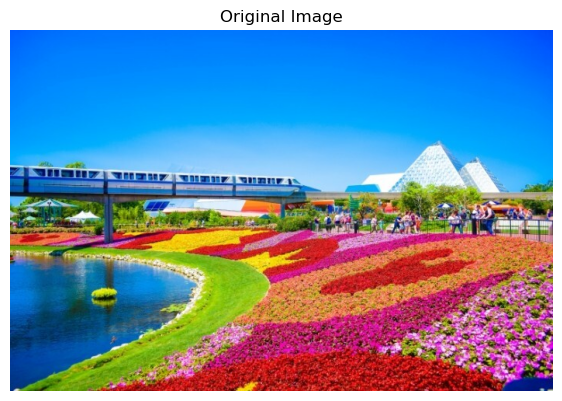

In [5]:
draw_picture(img, 'Original Image')

In [6]:
img.shape

(466, 700, 3)

В связи с ограниченностью ОЗУ (особенно при использовании модели `AgglomerativeClustering`), сожмём исходное изображение с сохранением пропорций.

In [7]:
import imutils

In [8]:
# Уменьшение размера изображения
img_reduced = imutils.resize(img, width=220)

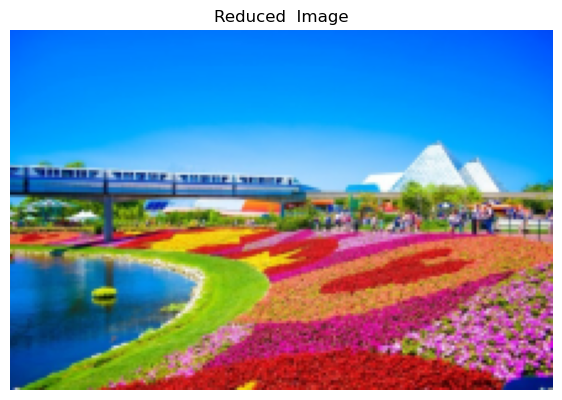

In [9]:
draw_picture(img_reduced, 'Reduced  Image')

In [10]:
img_reduced.shape

(146, 220, 3)

#### 2. Реализуйте три модели кластеризации. Для каждой модели оцените потери от уменьшения цветов при помощи метрики `SSIM`.

##### a) `KMeans`. Рассмотрите число кластеров K = 2, 5, 10, 20.

In [11]:
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans

In [12]:
# Преобразование изображения в одномерный массив пикселей
height, width, _ = img_reduced.shape
pixels = img_reduced.reshape(height * width, 3)

In [13]:
k_values = [2, 5, 10, 20]

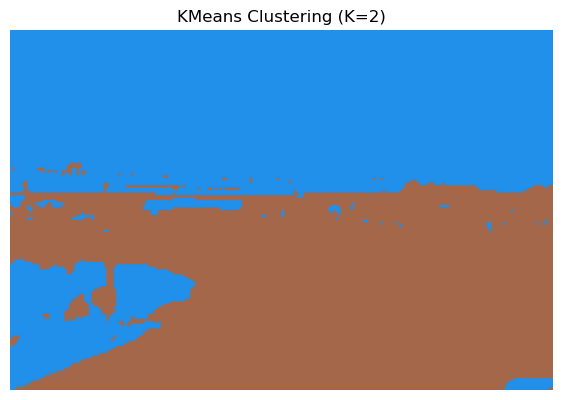

SSIM score for K=2: 0.33238860029222556


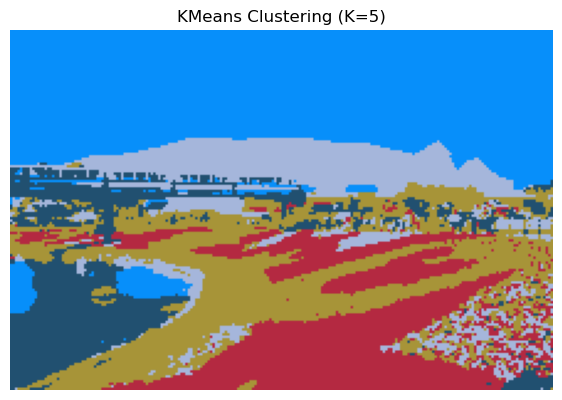

SSIM score for K=5: 0.5253377166667947


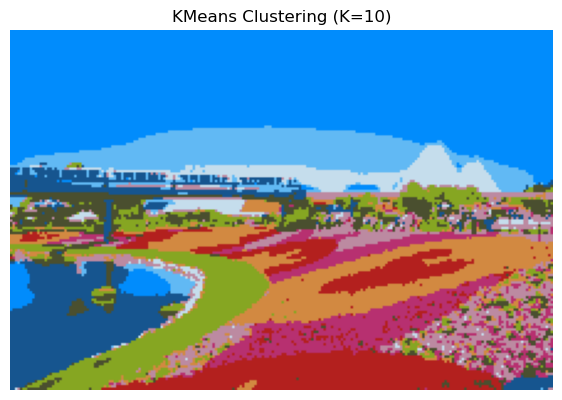

SSIM score for K=10: 0.7279178543892463


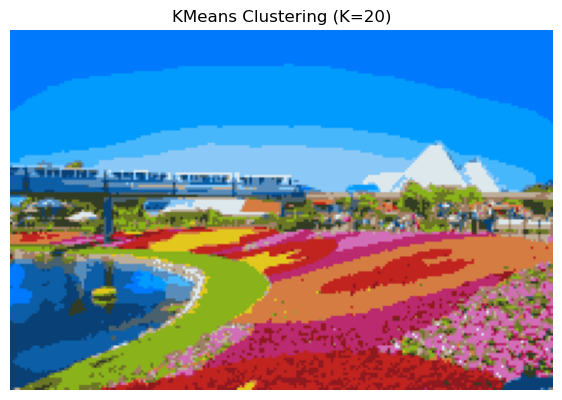

SSIM score for K=20: 0.8031502181955683


In [14]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixels)
    centroids = kmeans.cluster_centers_
    
    # Заполнение пикселей цветом центроидов
    new_pixels = centroids[labels]
    new_img = new_pixels.reshape(img_reduced.shape).astype(np.uint8)
     
    draw_picture(new_img, f'KMeans Clustering (K={k})')
    
    # Расчёт метрики SSIM
    ssim_score = ssim(img_reduced, new_img, multichannel=True)
    print(f'SSIM score for K={k}: {ssim_score}')

##### b) `DBSCAN`.

In [15]:
from sklearn.cluster import DBSCAN

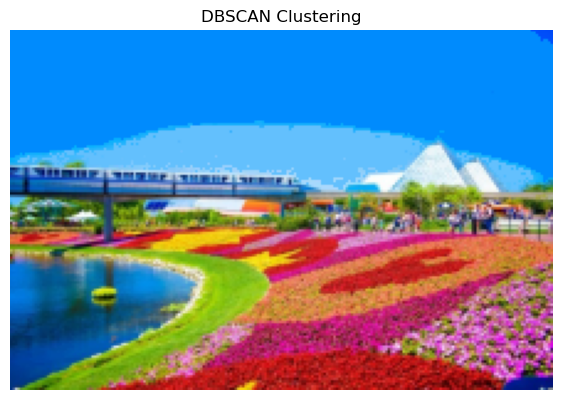

SSIM score = 0.9522723794091664


In [34]:
dbscan = DBSCAN(eps=1, min_samples=1)
labels = dbscan.fit_predict(pixels)
unique_labels = np.unique(labels)
centers = np.zeros_like(pixels)

for label in unique_labels:
    mask = (labels == label)
    cluster_center = pixels[mask].mean(axis=0)
    centers[mask] = cluster_center

new_img = centers.reshape(img_reduced.shape).astype('uint8')

draw_picture(new_img, 'DBSCAN Clustering')

# Расчёт метрики SSIM
ssim_score = ssim(img_reduced, new_img, multichannel=True)
print(f'SSIM score = {ssim_score}')

##### c) `AgglomerativeClustering`. Рассмотрите число кластеров K = 2, 5, 10, 20.

In [17]:
from sklearn.cluster import AgglomerativeClustering

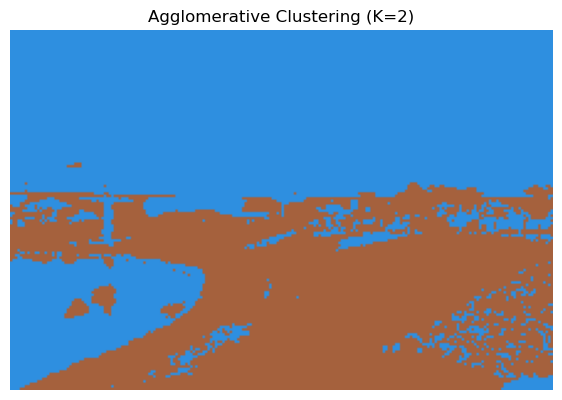

SSIM score for K=2: 0.351517875598179


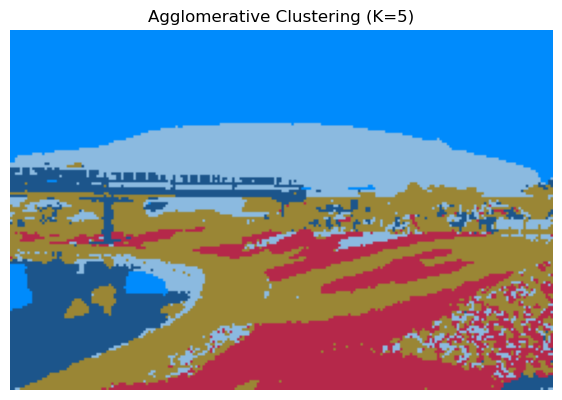

SSIM score for K=5: 0.5509500068110899


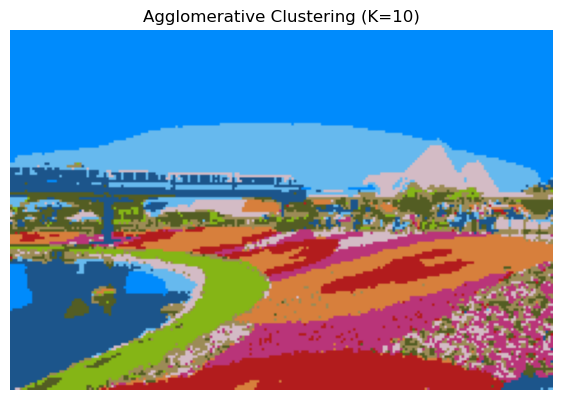

SSIM score for K=10: 0.7016194843563969


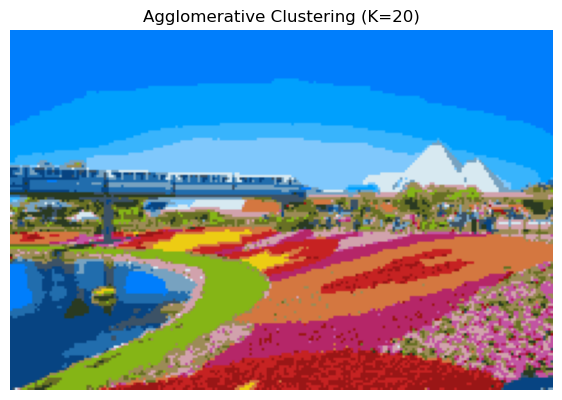

SSIM score for K=20: 0.7858156686412384


In [18]:
for k in k_values:
    agg_cluster = AgglomerativeClustering(n_clusters=k)
    labels = agg_cluster.fit_predict(pixels)
        
    # Получение центроидов кластеров
    centroids = np.zeros((k, 3))
    for i in range(k):
        cluster_pixels = pixels[labels == i]
        centroids[i] = np.mean(cluster_pixels, axis=0)
    
    # Заполнение пикселей одним цветом
    new_pixels = np.zeros_like(pixels)
    for i in range(k):
        new_pixels[labels == i] = centroids[i]       
        
    # Преобразование одномерного массива пикселей обратно в изображение
    new_img = new_pixels.reshape(img_reduced.shape).astype(np.uint8)
    
    draw_picture(new_img, f'Agglomerative Clustering (K={k})')
    
    # Расчёт метрики SSIM
    ssim_score = ssim(img_reduced, new_img, multichannel=True)
    print(f'SSIM score for K={k}: {ssim_score}')

#### 3. Сформулируйте выводы по проделанной работе.

Наилучший результат по метрике `SSIM` (да, и наглядно тоже) показала модель `DBSCAN`.  
Для `KMeans` и `AgglomerativeClustering` значения метрики оказались схожими, однако, модель `AgglomerativeClustering` выполнялась значительно дольше при значительно большей нагрузке на систему. 